In [249]:
"""
auteur:Alexandre
date:2024/09/05

Utilsation d'un algorithme de machine learning supervisé pour trouvé des paramètres permettant de prédire le résultats des élections
On cherche donc à prédire le partis gagnant en fonction de divers paramètres des bureax de votes
"""

"\nauteur:Alexandre\ndate:2024/09/05\n\nUtilsation d'un algorithme de machine learning supervisé pour trouvé des paramètres permettant de prédire le résultats des élections\nOn cherche donc à prédire le partis gagnant en fonction de divers paramètres des bureax de votes\n"

# **Analyse supervisée des bureaux de votes**

In [250]:
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os

## Importation des données

In [251]:
import preprocessing as pp
import params as prm

In [252]:
data_2 = pp.load_data(file_name=f"{prm.dataset_2nd_tour}.csv")
df, Gagnant = pp.prepare_supervised(df=data_2)

## Model de classification

In [253]:
import torch
from torch.utils.data import DataLoader, TensorDataset

In [254]:
class Decodeur(torch.nn.Module):
    def __init__(self, N_1, N_2):
        super(Decodeur, self).__init__()

        self.linear = torch.nn.Linear(in_features=N_1, out_features=N_2)
        self.logsoftmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self, x):
        
        x_in = self.linear(x)
        output = self.logsoftmax(x_in)
        
        return output

In [255]:
def fit_data(
    X,
    Y,
    
    lr=1e-6,
    batch_size=64,
    num_epochs=500,
    
    seed=2022,
    device="cuda"
):
    # Paramètrage des calculs
    if device == "cpu":
        print(f"Il semble y avoir {os.cpu_count()} coeurs dans cet ordi !")
    elif device == "cuda":
        if torch.cuda.is_available() == True:
            print("GPU ! GPU ! GPU !")
    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if device == "cuda": torch.cuda.empty_cache()

    # Preparation des données
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, 
        test_size=.2, 
        random_state=seed, 
        shuffle=True,
    )

    loader = DataLoader(
                    TensorDataset(
                        torch.Tensor(X_train).to(device), 
                        torch.Tensor(Y_train).to(device)
                    ), batch_size=batch_size, shuffle=True
                )
    
    # Préparation du modèle
    N_1, N_2 = X.shape[-1], np.unique(Y).shape[0]
    decodeur = Decodeur(
        N_1=N_1,
        N_2=N_2
    )
    decodeur = decodeur.to(device)

    # Préparation de l'apprentissage
    optimizer = torch.optim.Adam(
        decodeur.parameters(), 
        lr=lr
    )
    criterion = torch.nn.NLLLoss(reduction="mean")

    losses_train = []
    losses_test = []

    for epoch in tqdm(range(int(num_epochs)), desc=f"Computing on {device}"):
        
        for x, y in loader:

            x, y = x.to(device), y.to(device)
            
            y_pred = decodeur(x)
            
            loss_train = criterion(y_pred, y.long())
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()

        losses_train.append(loss_train.cpu().detach().item())

        with torch.no_grad():
            
            x_test = torch.Tensor(X_test).to(device)
            y_test = torch.Tensor(Y_test).to(device)

            y_pred = decodeur(x_test)

            losse_test = criterion(y_pred, y_test.long())

            losses_test.append(losse_test.cpu().detach().item())

    return decodeur, np.array(losses_train), np.array(losses_test), y_test.cpu().detach().numpy(), y_pred.cpu().detach().numpy()

## Départements

In [256]:
X = df["Code département"]
Y = Gagnant

In [257]:
OHE_departements = OneHotEncoder(sparse_output=False).fit(X.to_numpy()[:,None])
X_r = OHE_departements.transform(X.to_numpy()[:,None])
Encoder_departements = LabelEncoder().fit(Y.to_numpy())
Y_r = Encoder_departements.transform(Y.to_numpy())

In [258]:
num_epoch = 500
batch_size = 2**5
lr = 1e-5

In [259]:
decodeur, losses_train, losses_test, y_test, y_pred = fit_data(
    X=X_r,
    Y=Y_r,
    device="cpu",
    num_epochs=num_epoch,
    batch_size=batch_size,
    lr=lr
)
Weights = torch.softmax(decodeur.linear.weight.cpu(), axis=1).detach().numpy()

Il semble y avoir 16 coeurs dans cet ordi !


Computing on cpu: 100%|██████████| 500/500 [10:04<00:00,  1.21s/it]


In [260]:
# Path pour l'enregistrement des données
results_path = os.path.join(prm.cwd, "results")
result_path = os.path.join(results_path,f"C1_departement_{len(os.listdir(results_path))}")

# Enregistrement des données
if not(os.path.exists(result_path)):
    os.mkdir(result_path)
np.save(os.path.join(result_path, "loss_train"), losses_train)
np.save(os.path.join(result_path, "loss_test"), losses_test)
np.save(os.path.join(result_path, "pred"), y_pred)
np.save(os.path.join(result_path, "test"), y_test)

# Enregistrement des paramètres de l'entrainement
fichier = open(os.path.join(result_path, "info.txt"), "w")
fichier.write(f"{num_epoch = }\n")
fichier.write(f"{batch_size = }\n")
fichier.write(f"{lr = }")
fichier.close()

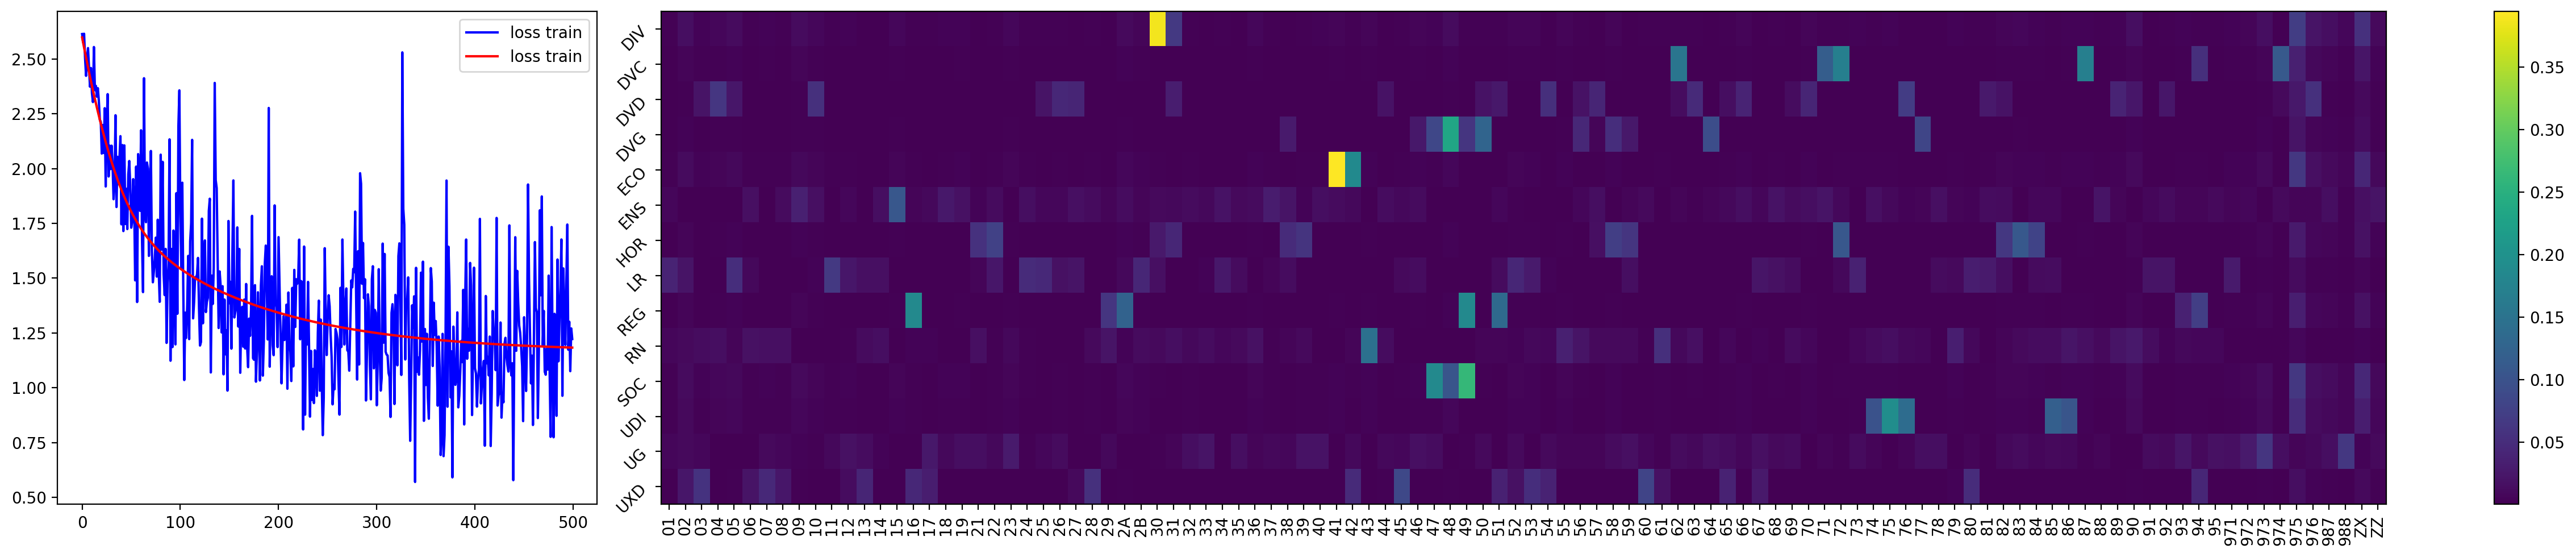

In [261]:
fig,ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(25,5),
    gridspec_kw={"width_ratios":[0.2,0.8]},
    dpi=200
)

ax[0].plot(
    range(num_epoch),
    losses_train,
    label="loss train",
    color="blue"
)
ax[0].plot(
    range(num_epoch),
    losses_test,
    label="loss train",
    color="red"
)
ax[0].legend()

g = ax[1].imshow(
    Weights,
    aspect="auto", cmap="viridis"
)
fig.colorbar(
    g,
    ax=ax[1]
)

ax[1].set_xticks(
    range(Weights.shape[-1]),
    OHE_departements.categories_[0],
    rotation=90
)

ax[1].set_yticks(
    range(Weights.shape[0]),
    Encoder_departements.classes_,
    rotation=45
)

plt.tight_layout()
plt.show()

## Participations

In [262]:
X = df[df.keys()[3:]]
Y = Gagnant
Encoder_departements = LabelEncoder().fit(Y.to_numpy())
Y_r = Encoder_departements.transform(Y.to_numpy())
Robustscaler = RobustScaler().fit(X.T)
X_r = Robustscaler.transform(X.T).T

In [263]:
num_epoch = 100
batch_size = 2**5
lr = 1e-5

In [264]:
decodeur, losses_train, losses_test, y_test, y_pred = fit_data(
    X=X_r,
    Y=Y_r,
    device="cpu",
    num_epochs=num_epoch,
    batch_size=batch_size,
    lr=lr
)
Weights = torch.softmax(decodeur.linear.weight.cpu(), axis=1).detach().numpy()

Il semble y avoir 16 coeurs dans cet ordi !


Computing on cpu: 100%|██████████| 100/100 [01:56<00:00,  1.17s/it]


In [247]:
# Path pour l'enregistrement des données
results_path = os.path.join(prm.cwd, "results")
result_path = os.path.join(results_path,f"C1_participation_{len(os.listdir(results_path))}")

# Enregistrement des données
if not(os.path.exists(result_path)):
    os.mkdir(result_path)
np.save(os.path.join(result_path, "loss_train"), losses_train)
np.save(os.path.join(result_path, "loss_test"), losses_test)
np.save(os.path.join(result_path, "pred"), y_pred)
np.save(os.path.join(result_path, "test"), y_test)

# Enregistrement des paramètres de l'entrainement
fichier = open(os.path.join(result_path, "info.txt"), "w")
fichier.write(f"{num_epoch = }\n")
fichier.write(f"{batch_size = }\n")
fichier.write(f"{lr = }")
fichier.close()

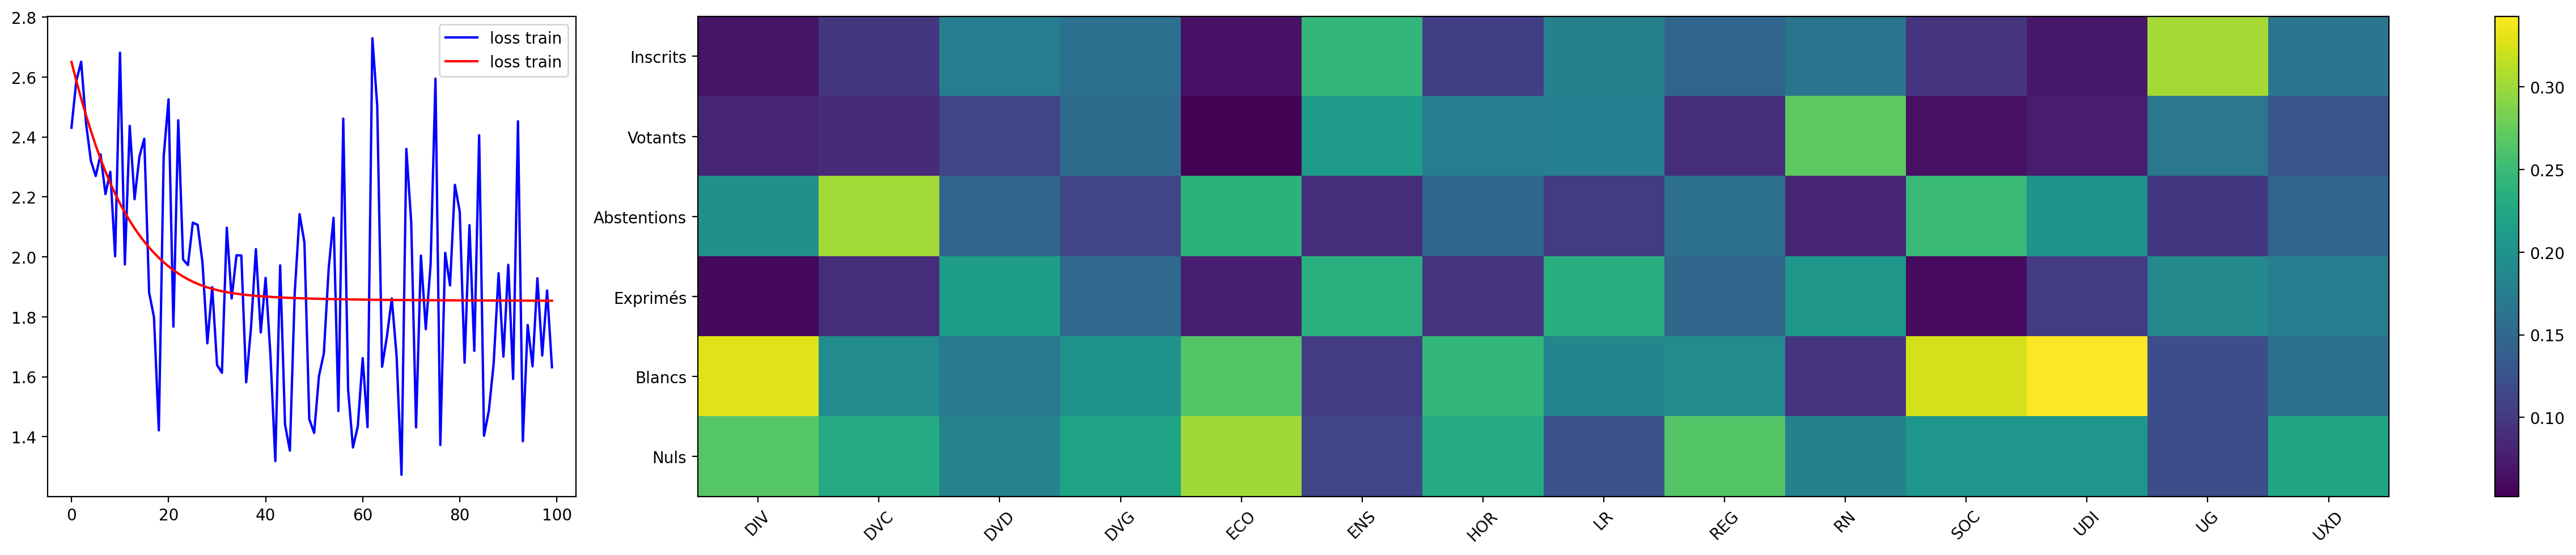

In [265]:
fig,ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(25,5),
    gridspec_kw={"width_ratios":[0.2,0.8]},
    dpi=200
)

ax[0].plot(
    range(num_epoch),
    losses_train,
    label="loss train",
    color="blue"
)
ax[0].plot(
    range(num_epoch),
    losses_test,
    label="loss train",
    color="red"
)
ax[0].legend()

g = ax[1].imshow(
    Weights.T,
    aspect="auto", cmap="viridis"
)
fig.colorbar(
    g,
    ax=ax[1]
)

ax[1].set_yticks(
    range(Weights.shape[-1]),
    df.keys()[3:]
)

ax[1].set_xticks(
    range(Weights.shape[0]),
    Encoder_departements.classes_,
    rotation=45
)

plt.tight_layout()
plt.show()